# EDA: PPE Detection v10

In [1]:
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pandas as pd
import json
import math

# reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# paths
LABEL_DIR = Path("../data_yolo/train/labels")
IMG_DIR = Path("../data_yolo/train/images")
OUTPUT_DIR = Path("./eda_outputs")  # path where your earlier run saved outputs

# class id mapping
id2name = {0: "person", 1: "head", 2: "helmet"}
name2id = {v:k for k,v in id2name.items()}

plt.rcParams.update({"figure.figsize": (8,5)})


In [2]:
# basic overview: counts and example label preview
label_files = sorted(list(LABEL_DIR.glob("*.txt")))
image_files = sorted(list(IMG_DIR.glob("*.jpg")))

n_label_files = len(label_files)
n_image_files = len(image_files)
print(f"Label files found: {n_label_files}")
print(f"Image files found: {n_image_files}")

# class instance counts (from YOLO label files)
class_counter = Counter()
example_label_preview = None
for label_file in label_files:
    with open(label_file) as f:
        lines = [ln.strip() for ln in f if ln.strip()]
        if not example_label_preview and lines:
            example_label_preview = lines[:10]
        for line in lines:
            try:
                cls_id = int(line.split()[0])
                class_counter[cls_id] += 1
            except:
                pass

total_annotations = sum(class_counter.values())
print("class_counter (id -> count):", dict(class_counter))
print("Total annotations:", total_annotations)

print("\nExample label preview (first non-empty file):")
if example_label_preview:
    for ln in example_label_preview:
        print(" ", ln)
else:
    print("  (no label content found)")

# explicit id <-> name mapping and readable counts
print("id -> name mapping (current):", id2name)
print("\nReadable class counts:")
for iid, cnt in sorted(class_counter.items()):
    print(f"  ID {iid} -> {id2name.get(iid,'UNKNOWN')}: {cnt}")


Label files found: 4916
Image files found: 4916
class_counter (id -> count): {2: 13919, 1: 4612, 0: 450}
Total annotations: 18981

Example label preview (first non-empty file):
  2 0.408 0.30266666666666664 0.104 0.15733333333333333
  2 0.245 0.424 0.046 0.08
id -> name mapping (current): {0: 'person', 1: 'head', 2: 'helmet'}

Readable class counts:
  ID 0 -> person: 450
  ID 1 -> head: 4612
  ID 2 -> helmet: 13919


**Findings**

- `n_label_files` = **4916**, `n_image_files` = **4916**. (All images have corresponding label files.)
- `total_annotations` = **18,981**.
- Class counts:
  - `helmet`: **13,919**
  - `head`: **4,612**
  - `person`: **450**

The dataset is annotation-heavy for helmets and sparse for `person`, which is typical for PPE datasets where helmets are annotated independently.


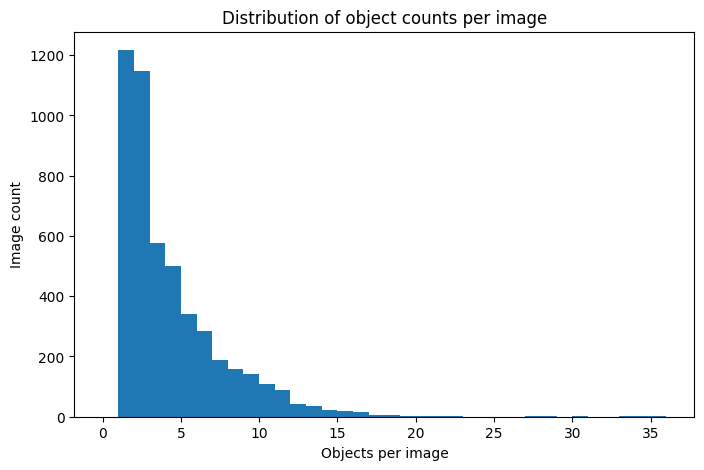

median objects/image: 3.0
mean objects/image: 3.86106590724166
max objects in an image: 35

Top images by object count (stem -> count):
004819_jpg.rf.ebbb18a4bd04d48b69b3ebb21e7e92a4 35
002463_jpg.rf.066f52df5491c94fc7d30c47596217c9 34
002646_jpg.rf.c9ac6b967a34f0c5fe0541170028717f 33
003356_jpg.rf.5ab71bd2f617499038c45c86439c7888 33
002290_jpg.rf.0a0969a878ead1c437eb42ced82c132c 30
002223_jpg.rf.763ce069264246fc0c7f4d04dd584cb9 28
004837_jpg.rf.cdd3b03f11eacde99a11d359e083c7f2 27
003735_jpg.rf.69099915a03e61c518e40413a64117f5 22
000338_jpg.rf.46ae2f92840ff15499a769e603c9efab 21
000311_jpg.rf.1c953021812b4496abfcc8d90968f061 20


In [3]:
# objects per image histogram and top-outlier images
image_counts = defaultdict(int)
for label_file in label_files:
    with open(label_file) as f:
        for _ in f:
            image_counts[label_file.stem] += 1

counts = list(image_counts.values()) if image_counts else [0]
plt.hist(counts, bins=range(0, max(counts)+2 if counts else 2))
plt.xlabel('Objects per image')
plt.ylabel('Image count')
plt.title('Distribution of object counts per image')
plt.show()

print('median objects/image:', float(np.median(counts)))
print('mean objects/image:', float(np.mean(counts)))
print('max objects in an image:', int(max(counts)))

# top images by number of objects
top_k = 10
top_images = sorted(image_counts.items(), key=lambda x: x[1], reverse=True)[:top_k]
print('\nTop images by object count (stem -> count):')
for stem, c in top_images:
    print(stem, c)


**Findings**

- `n_images_with_labels`: **4916**
- **Median objects/image** = **3.0**
- **Mean objects/image** = **3.861**
- **Max objects in an image** = **35**

Interpretation:
- Typical images contain ~3 objects; this influences batch construction and augmentation strategies (mosaic augmentation may be useful but be wary of over-crowding images that already have many boxes).


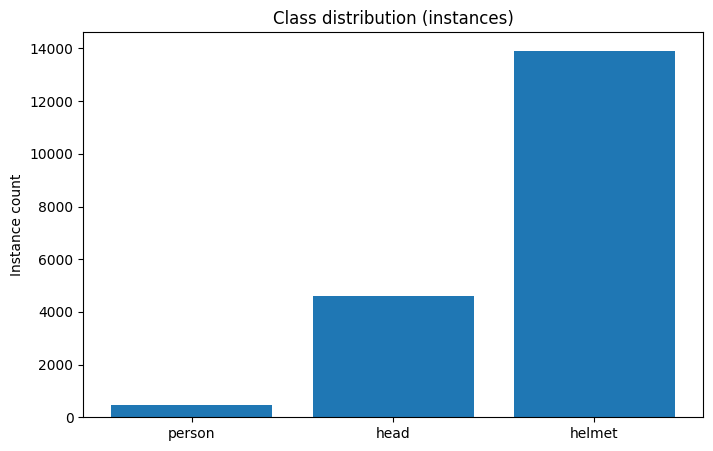

person: 450 (2.37%)
head: 4612 (24.30%)
helmet: 13919 (73.33%)


In [4]:
# class distribution (bar plot + percentages)
classes = [id2name.get(i, str(i)) for i in sorted(class_counter.keys())]
counts = [class_counter[i] for i in sorted(class_counter.keys())]

plt.bar(classes, counts)
plt.ylabel('Instance count')
plt.title('Class distribution (instances)')
plt.show()

total = sum(counts)
for cls, c in zip(classes, counts):
    print(f"{cls}: {c} ({c/total*100:.2f}%)")


**Findings**

- `helmet`: **13,919** (≈ **73.3%** of annotations)
- `head`: **4,612** (≈ **24.3%**)
- `person`: **450** (≈ **2.4%**)

Interpretation:
- Strong class imbalance (helmets dominate). This will influence loss behavior and per-class evaluation.

In [5]:
# image level counts
images_with_person = set()
images_with_head = set()
images_with_helmet = set()

for label_file in label_files:
    with open(label_file) as f:
        for line in f:
            cls_id = int(line.split()[0])
            if cls_id == 0:
                images_with_person.add(label_file.stem)
            elif cls_id == 1:
                images_with_head.add(label_file.stem)
            elif cls_id == 2:
                images_with_helmet.add(label_file.stem)

print(f"\nImage-level class distribution:")
print(f"  Images with person:  {len(images_with_person):4d} ({len(images_with_person)/n_image_files*100:5.1f}%)")
print(f"  Images with head:    {len(images_with_head):4d} ({len(images_with_head)/n_image_files*100:5.1f}%)")
print(f"  Images with helmet:  {len(images_with_helmet):4d} ({len(images_with_helmet)/n_image_files*100:5.1f}%)")
print(f"\n  Average persons per image (when present): {450/len(images_with_person):.2f}")
print(f"  Average heads per image (when present):   {4612/len(images_with_head):.2f}")
print(f"  Average helmets per image (when present): {13919/len(images_with_helmet):.2f}")


Image-level class distribution:
  Images with person:   154 (  3.1%)
  Images with head:     911 ( 18.5%)
  Images with helmet:  4503 ( 91.6%)

  Average persons per image (when present): 2.92
  Average heads per image (when present):   5.06
  Average helmets per image (when present): 3.09


**Findings**
  
Only 154 images (≈3.1%) contain `person` annotations, so person coverage is very limited. `helmet` appears in the vast majority of images (≈91.6%), while `head` appears in about 18.5% of images. When present, an image typically contains ~2.9 persons, ~5.1 heads, or ~3.1 helmets on average.

**Interpretation**  

The dataset is heavily biased toward detecting helmets rather than full people. Because `person` examples are so scarce, there may be weak person recall and a high risk of overfitting on person examples.


In [6]:
# Class co-occurrence
co_occurrence = Counter()

for label_file in label_files:
    classes_in_image = set()
    with open(label_file) as f:
        for line in f:
            cls_id = int(line.split()[0])
            classes_in_image.add(cls_id)
    
    # Convert to sorted tuple
    if classes_in_image:
        pattern = tuple(sorted(classes_in_image))
        co_occurrence[pattern] += 1

print(f"\nClass Co-occurrence Patterns:")
print(f"{'Pattern':<30} {'Images':>7} {'%':>6}")
print("-" * 45)

pattern_names = {
    (0,): "person only",
    (1,): "head only",
    (2,): "helmet only",
    (0, 1): "person + head",
    (0, 2): "person + helmet",
    (1, 2): "head + helmet",
    (0, 1, 2): "person + head + helmet"
}

for pattern, count in sorted(co_occurrence.items(), key=lambda x: x[1], reverse=True):
    pattern_str = pattern_names.get(pattern, str(pattern))
    pct = (count / n_image_files) * 100
    print(f"{pattern_str:<30} {count:7d} {pct:5.1f}%")


Class Co-occurrence Patterns:
Pattern                         Images      %
---------------------------------------------
helmet only                       3869  78.7%
head + helmet                      480   9.8%
head only                          413   8.4%
person + helmet                    136   2.8%
person + head + helmet              18   0.4%


**Findings**  

Most images (≈78.7%) contain helmets only, with no other annotations. Images showing `head + helmet` are ~9.8%, `head` only are ~8.4%, `person + helmet` ~2.8%, and the full context `person + head + helmet` is essentially absent (~0.4%, 18 images).

**Interpretation**  

The dataset mostly contains isolated helmet objects and provides very little contextual footage of people wearing helmets. This means the data cannot reliably teach models to link helmets to persons for compliance checks.


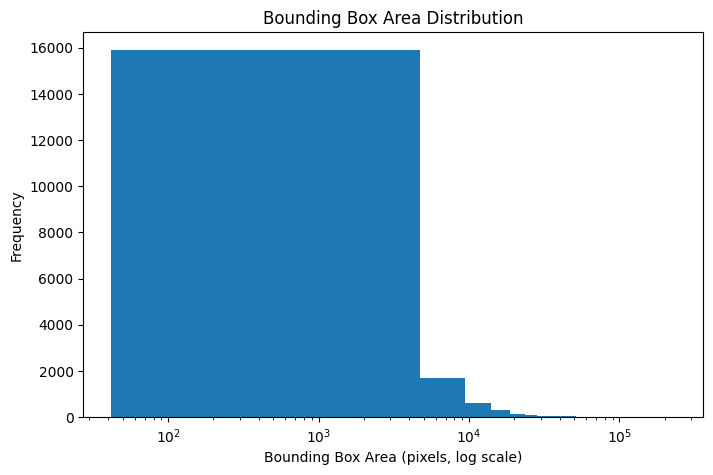

Total boxes: 18981
Overall median bbox area: 1240.0
Overall mean bbox area: 3451.07433749539

Per-class bbox stats (median, mean, count):
Class 2: median=1326.0, mean=3461.48, count=13919
Class 1: median=980.0, mean=1596.31, count=4612
Class 0: median=13114.5, mean=22138.57, count=450


In [7]:
# bounding box areas (absolute pixels); overall and per-class summary

bbox_areas = []
per_class_areas = defaultdict(list)

for lf in label_files:
    img_path = IMG_DIR / (lf.stem + ".jpg")
    img = cv2.imread(str(img_path))
    if img is None:
        continue
    h, w = img.shape[:2]

    with open(lf) as f:
        for ln in f:
            parts = ln.split()
            if len(parts) < 5:
                continue
            cls, xc, yc, bw, bh = map(float, parts[:5])
            area = (bw * w) * (bh * h)
            bbox_areas.append(area)
            per_class_areas[int(cls)].append(area)

# Plot distribution
plt.hist(bbox_areas, bins=50)
plt.xscale('log')
plt.xlabel('Bounding Box Area (pixels, log scale)')
plt.ylabel('Frequency')
plt.title('Bounding Box Area Distribution')
plt.show()


print("Total boxes:", len(bbox_areas))
print("Overall median bbox area:", np.median(bbox_areas))
print("Overall mean bbox area:", np.mean(bbox_areas))

print("\nPer-class bbox stats (median, mean, count):")
for cls_id, areas in per_class_areas.items():
    print(f"Class {cls_id}: median={np.median(areas):.1f}, mean={np.mean(areas):.2f}, count={len(areas)}")

**Findings**

- `total_boxes` = **18,981**
- **Overall median bbox area** = **1240 px**
- **Overall mean bbox area** = **3,451.07 px**

Per-class:
- `helmet`: median **1,326 px**, mean **3,461.48 px**, n = **13,919**
- `head`:   median **980 px**, mean **1,596.31 px**, n = **4,612**
- `person`: median **13,114.5 px**, mean **22,138.57 px**, n = **450**

Interpretation:
- Helmets and heads are small relative to image size (helmet median ~1.3k px); consistent with small-object detection challenges. `person` is much larger on average.
- Small-object prevalence justifies the 640×640 input size starting point.

In [8]:
# COCO small/medium/large thresholds
small_count = sum(1 for area in bbox_areas if area < 32**2)  # <1024px
medium_count = sum(1 for area in bbox_areas if 32**2 <= area < 96**2)  # 1024-9216px
large_count = sum(1 for area in bbox_areas if area >= 96**2)  # >9216px

total = len(bbox_areas)
print(f"\nCOCO Size Categories:")
print(f"  Small (<32²):    {small_count:5d} ({small_count/total*100:5.1f}%)")
print(f"  Medium (32²-96²): {medium_count:5d} ({medium_count/total*100:5.1f}%)")
print(f"  Large (>96²):    {large_count:5d} ({large_count/total*100:5.1f}%)")

# Per-class breakdown
print(f"\nPer-class size distribution:")
for cls_id, areas in per_class_areas.items():
    cls_name = id2name[cls_id]
    small = sum(1 for a in areas if a < 32**2)
    medium = sum(1 for a in areas if 32**2 <= a < 96**2)
    large = sum(1 for a in areas if a >= 96**2)
    print(f"  {cls_name:8s}: Small={small:5d} ({small/len(areas)*100:4.1f}%), "
          f"Medium={medium:5d} ({medium/len(areas)*100:4.1f}%), "
          f"Large={large:5d} ({large/len(areas)*100:4.1f}%)")


COCO Size Categories:
  Small (<32²):     8254 ( 43.5%)
  Medium (32²-96²):  9257 ( 48.8%)
  Large (>96²):     1470 (  7.7%)

Per-class size distribution:
  helmet  : Small= 5827 (41.9%), Medium= 6940 (49.9%), Large= 1152 ( 8.3%)
  head    : Small= 2413 (52.3%), Medium= 2147 (46.6%), Large=   52 ( 1.1%)
  person  : Small=   14 ( 3.1%), Medium=  170 (37.8%), Large=  266 (59.1%)


**Findings**  

Overall object-size breakdown: small ≈43.5%, medium ≈48.8%, large ≈7.7%. By class: heads are the smallest (≈52% small), helmets are split between small and medium (~42% small, ~50% medium), and persons are mostly large (~59% large).

**Interpretation**

Small-object detection is a core challenge (≈43% small). Expecting the largest drop under blur/low-light for `head` (most small) and a notable drop for `helmet` as well. `person` should be more robust size-wise but is underrepresented. 640×640 is a practical starting input size and prioritize small-object-focused strategies (multi-scale inference, targeted augmentations, and low-light/super-resolution experiments).


In [9]:
# resolution and aspect ratio distribution
widths = []
heights = []
for p in IMG_DIR.glob("*.jpg"):
    img = cv2.imread(str(p))
    if img is None: continue
    h,w = img.shape[:2]
    widths.append(w)
    heights.append(h)

if widths:
    print("images counted:", len(widths))
    print("width min/max/median:", min(widths), max(widths), int(np.median(widths)))
    print("height min/max/median:", min(heights), max(heights), int(np.median(heights)))
    print("median aspect ratio w/h:", float(np.median(np.array(widths)/np.array(heights))))
else:
    print("No images found or they couldn't be read.")


images counted: 4916
width min/max/median: 179 1000 500
height min/max/median: 136 963 333
median aspect ratio w/h: 1.5


**Findings**

- Images: **4916** with resolution data.
- Width range: **179 — 1000**, median **500 px**.
- Height range: **136 — 963**, median **333 px**.
- Median aspect ratio (w/h): **1.5**.

Interpretation:
- Many images are relatively low-res (example median 500×333). That supports using 640×640 input (good balance between preserving small details and GPU memory).
- Aspect ratio median 1.5 implies many images are rectangular; however standard letterbox-to-square is fine if we use consistent preprocessing for all experiments.


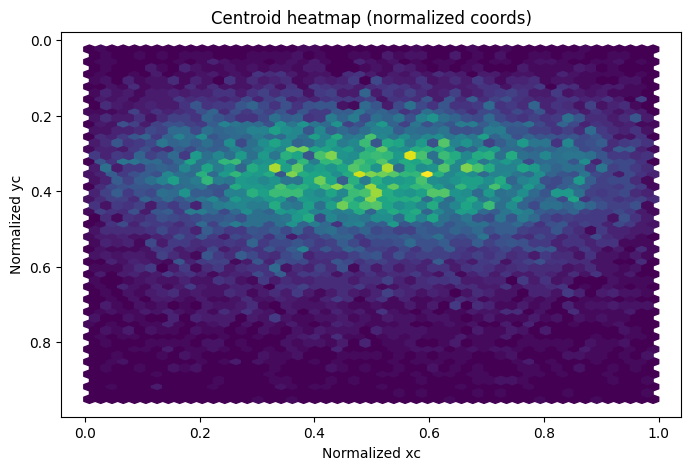

In [10]:
# centroid heatmap
centers_x = []
centers_y = []
for lf in LABEL_DIR.glob("*.txt"):
    with open(lf) as f:
        for ln in f:
            parts = ln.split()
            if len(parts) < 5: continue
            _, xc, yc, bw, bh = map(float, parts[:5])
            centers_x.append(xc)
            centers_y.append(yc)

if centers_x:
    plt.hexbin(centers_x, centers_y, gridsize=50)
    plt.gca().invert_yaxis()
    plt.xlabel('Normalized xc')
    plt.ylabel('Normalized yc')
    plt.title('Centroid heatmap (normalized coords)')
    plt.show()
else:
    print("No centroid data available.")

**Findings**

- The centroid heatmap shows a clear concentration of object centers near the middle of the image, especially around (0.5, 0.4) in normalized coordinates.

Interpretation:
- This spatial bias suggests that many objects are positioned centrally, which is common in human-annotated datasets or helmet/head detection tasks.


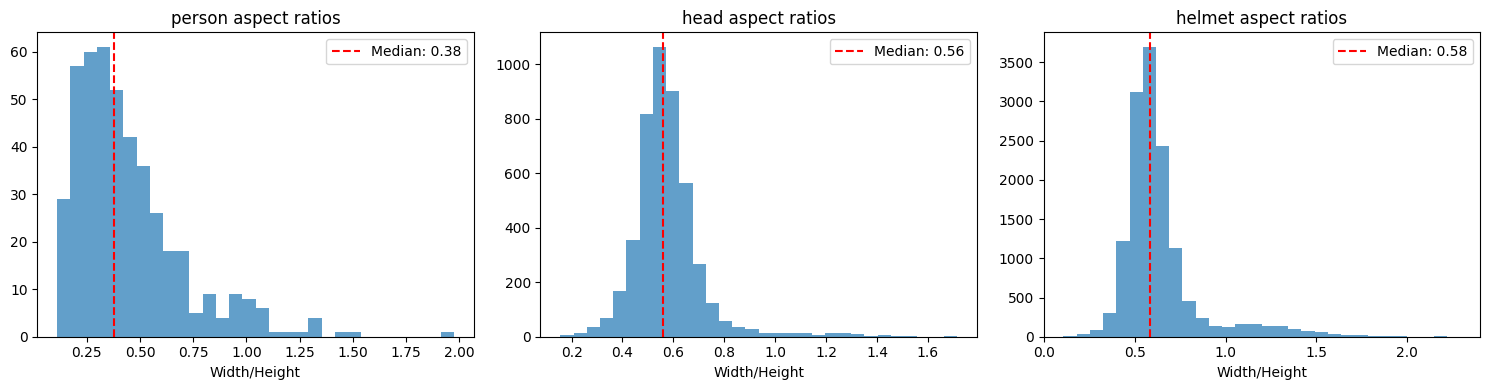

person  : median AR = 0.38
head    : median AR = 0.56
helmet  : median AR = 0.58


In [11]:
# Aspect ratios per class
aspect_ratios_per_class = defaultdict(list)

for lf in label_files:
    img_path = IMG_DIR / (lf.stem + ".jpg")
    img = cv2.imread(str(img_path))
    if img is None:
        continue
    h, w = img.shape[:2]
    
    with open(lf) as f:
        for ln in f:
            parts = ln.split()
            if len(parts) < 5:
                continue
            cls, xc, yc, bw, bh = map(float, parts[:5])
            aspect_ratio = bw / bh if bh > 0 else 0
            aspect_ratios_per_class[int(cls)].append(aspect_ratio)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, (cls_id, ratios) in enumerate(sorted(aspect_ratios_per_class.items())):
    axes[i].hist(ratios, bins=30, alpha=0.7)
    axes[i].axvline(np.median(ratios), color='red', linestyle='--', label=f'Median: {np.median(ratios):.2f}')
    axes[i].set_title(f'{id2name[cls_id]} aspect ratios')
    axes[i].set_xlabel('Width/Height')
    axes[i].legend()
plt.tight_layout()
plt.show()

for cls_id, ratios in sorted(aspect_ratios_per_class.items()):
    print(f"{id2name[cls_id]:8s}: median AR = {np.median(ratios):.2f}")

**Findings** 

Median height/width ratios are distinct: `person` ≈ 0.38 (tall/vertical), `head` ≈ 0.56, `helmet` ≈ 0.58 (both roughly near-square).

**Interpretation**

Person boxes are vertically elongated and thus mainly separable by shape, while head and helmet boxes are similar in shape and require texture/appearance cues to distinguish. Corruptions that degrade texture (motion blur, low light) are therefore likely to increase head↔helmet confusion, while person detection will rely more on shape cues. Design training/augmentation and evaluation accordingly.

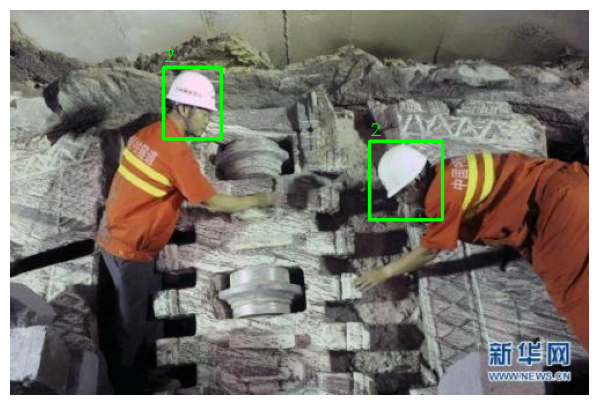

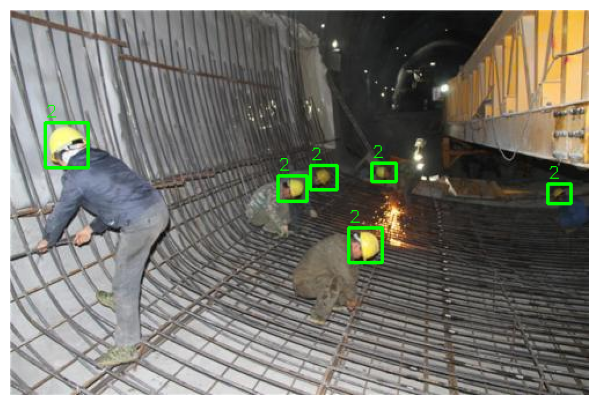

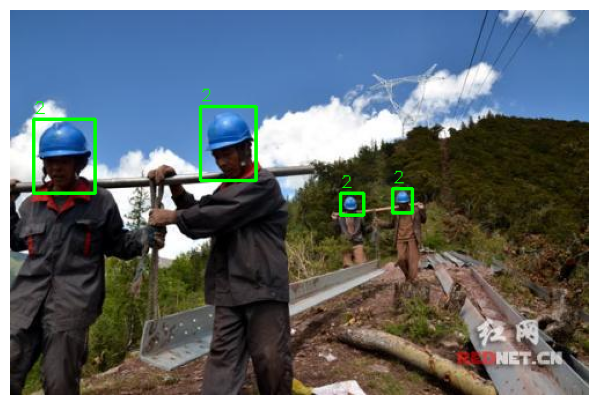

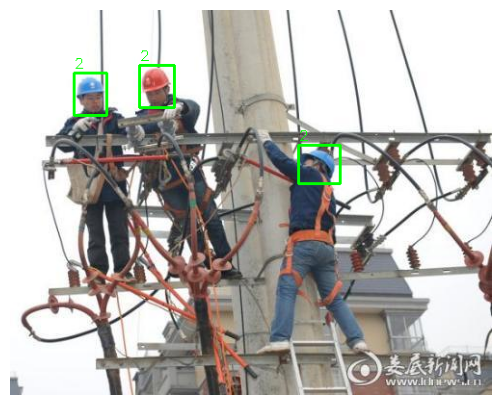

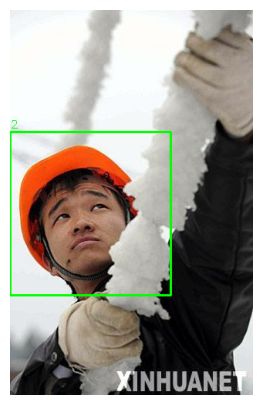

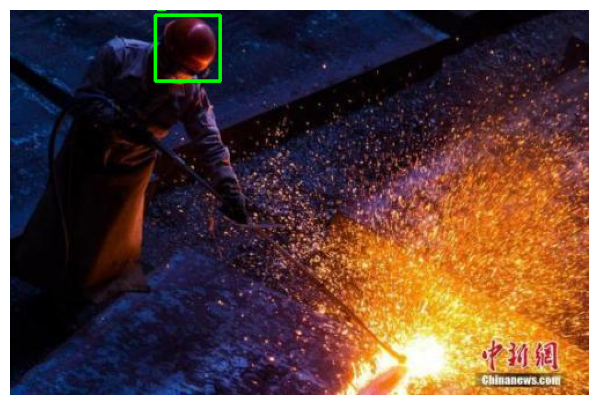

In [12]:
SAMPLES = 6
image_list = [p for p in IMG_DIR.glob("*.jpg") if (LABEL_DIR / (p.stem + ".txt")).exists()]
sample_imgs = random.sample(image_list, min(SAMPLES, len(image_list)))
for img_p in sample_imgs:
    img = cv2.imread(str(img_p))
    if img is None: continue
    h,w = img.shape[:2]
    with open(LABEL_DIR / (img_p.stem + ".txt")) as f:
        for ln in f:
            parts = ln.split()
            if len(parts) < 5: continue
            cls, xc, yc, bw, bh = map(float, parts[:5])
            x1 = int((xc - bw/2) * w)
            y1 = int((yc - bh/2) * h)
            x2 = int((xc + bw/2) * w)
            y2 = int((yc + bh/2) * h)
            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
            cv2.putText(img, str(int(cls)), (x1, max(0,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    plt.figure(figsize=(8,5)); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.show()

**Findings**
- Visual inspection confirms that bounding boxes align correctly with target objects 
- Class assignments appear consistent 
- No systematic conversion errors are present

## EDA Key Points

### Dataset snapshot
- Images: **4,916** (70/20/10 split assumed).  
- Annotations: **18,981** total.  
- Median image size: **500 × 333**. Median objects/image: **3** (max 35).

### Core class facts 
- Instance mix: **helmet 73.3% (13,919)** · **head 24.3% (4,612)** · **person 2.4% (450)**.  
- Image-level coverage: **helmet in 91.6% of images**, **head 18.5%**, **person 3.1% (154 images)**.  
- Co-occurrence: **78.7% helmet-only** images; **person+head+helmet only 0.4% (18 images)**.

### Object-size summary
- COCO buckets overall: **small 43.5%**, medium 48.8%, large 7.7%.  
- Heads are the smallest (≈52% small); helmets ~42% small / ~50% medium; persons mostly large.

### Aspect-ratio note
- Median h/w: **person 0.38 (vertical)** vs **head/helmet ~0.56–0.58 (near-square)**; shape separates person; head vs helmet need texture.

### Top actionable implications
1. **Scope:** Treat this as a **helmet-detection** robustness study; _not_ a PPE compliance study (too few person+head+helmet examples).  
2. **Models:** Compare **YOLOv8m** (fast) vs **Faster R-CNN (ResNet50-FPN)** (stronger small-object handling).  
3. **Input size:** Use **640×640** baseline (balances small-object preservation and GPU cost).  
4. **Metrics to report:**  
   - Primary: **mAP@0.5 (overall + per-class)**.  
   - Also: **AP_small/AP_medium/AP_large**, per-class Precision/Recall/F1, and **FPS**.  
   - Degradation/Recovery: **ΔmAP (abs)** and **% recovery** after enhancement.    
5. **Augment / enhancement choices:** CLAHE / histogram equalization for low-light; sharpening / deblurring or SR for motion blur; small occlusion masks for occlusion tests.  
6. **Corruption intensities (possible ranges):**
   - Motion blur kernels: **[5, 10, 15] px**  
   - Low-light brightness multipliers: **[0.6, 0.4, 0.25]**  
   - Occlusion ratios: **[0.15, 0.25, 0.35]**  
8. **Evaluation:** Overall mAP will be dominated by helmets due to class imbalance. Consider macro-averaged metrics or per-class weighting for balanced scoring.

### Key limitations to state in the report
- **Person detection is underpowered** (154 images) → high variance and likely low recall.  
- **Compliance detection not supported** by dataset (only 18 images with full person+head+helmet).  
- Results are sensitive to small-object corruption choices (≈43% small objects).
